In [84]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from matplotlib import cm, colors

%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
import scipy.stats as stats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
class Line:
    """
    Creates a line object with a speed, offset and width. Lines are drawn in an image with gen_image. 
    Currently only gauss type lines work. These are all normalized such that the sum over space (x) = 1. 
    With this normalization we would expect the net transport over time graph to increase by one for every line that it crosses. 
    """
    def __init__(self,speed, offset, line_type="gauss", width=5, intens = 1):
        self.line_type=line_type
        self.width = width
        self.speed = speed
        self.direc = np.sign(self.speed)
        self.offset = offset
        return None
        
    def block(self, array, speed_offset, normalize=False):
        if not normalize:
            return (np.heaviside(array - speed_offset + self.width, 0.5) - np.heaviside(array - speed_offset - self.width, 0.5))
        else:
            out_arr = (np.heaviside(array - speed_offset + self.width, 0.5) - np.heaviside(array - speed_offset - self.width, 0.5))
            return out_arr / np.sum(out_arr)
        
    def gauss(self, array, speed_offset, normalize = False):
        return stats.norm.pdf(array, speed_offset, self.width)
        
    def gen_image(self, x_res, y_res, normalize = False):
        x_line = np.linspace(0, x_res-1, x_res)
        line_pos = np.linspace(self.offset, self.offset + self.speed*y_res, y_res)
        if self.line_type == "block":
            line_img = [self.block(x_line, v_offset, normalize=normalize) for v_offset in line_pos]
        elif self.line_type == "gauss":
            line_img = [self.gauss(x_line, v_offset, normalize=normalize) for v_offset in line_pos]
        return line_img
    
# def gen_feather(img, height, zero_frac):
#     zero_thresh = int(height * zero_frac)
#     feather = np.linspace(0,1, height - zero_thresh)
#     out_img = img.copy()
#     for i in range(zero_thresh):
#         out_img[-1-i] *= 0
#     for i, j in enumerate(range(zero_thresh, height)):
#         out_img[-1-j] *= feather[i]
#     return out_img

def kymo_titles(axis, title):
    axis.set_title(title)
    axis.set_xlabel("space (x)")
    axis.set_ylabel("time (t)")
    return None

def flux_int(img, line = 200):
    flux_max = np.max(abs(img.flatten()))
    [x_res, y_res] = np.shape(img)
    int_line = img.transpose()[line]
    int_plot = np.cumsum(int_line)
    fig, ax = plt.subplots(1,2)
    fig.tight_layout()
    
    ax[0].imshow(img, cmap='bwr', vmin = -1*flux_max, vmax = flux_max)
    ax[0].vlines(line, 0, x_res-1, colors='black')
    kymo_titles(ax[0], "Flux with integral line")
    
    ax[1].plot(int_plot, label="Ground Truth")
    ax[1].grid()
    ax[1].hlines(0, 0, x_res, colors='black', label="")
    ax[1].set_title("Net Transport")
    ax[1].set_xlabel("time (t)")
    ax[1].set_ylabel("transport (q)")
    ax[1].legend()
    return ax[1]




# Big Line Test doc

This document generates lines for analysis of the kymograph flux calculation algorithms. 

## Line Gen
The next piece of code generates these lines and sets up the ground truth for the flux calculation.

In [212]:
display_figs = True 
# Display debug figures (False for faster performance)
noise_thresh = 0.01
#Remove low intensity background noise from kymograph, needs to change once we're dealing with actual pixel values
speed_thresh = 10.0
#Puts an upper boundary to the function that finds speeds

nr_forw_lines = 100
nr_back_lines = 200
nr_total_lines = nr_forw_lines + nr_back_lines

x_res_kymo = 800
y_res_kymo = 400

# lines_left = []
# lines_right=  []
img_stack = []
img_forw_stack = []
img_back_stack = []
flux_stack = []
flux_stack_back = []
flux_stack_forw = []

forw_spd_adjust = 1.0
back_spd_adjust = 1.8

for i in range(nr_forw_lines):
    params = np.random.rand(3)
    params_proc = ((params[0] + 0.5) * forw_spd_adjust, 
                   int(params[1] * x_res_kymo) - int((params[0] + 0.5) * forw_spd_adjust*x_res_kymo / 2), 
                   (params[2]+0.5)*10)
#                    5)
#     lines_right.append(Line(params_proc[0], params_proc[1], width=params_proc[2]))
    line = Line(params_proc[0], params_proc[1], width=params_proc[2])
    
    img_forw = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True)) * 2.0
    img_stack.append(img_forw)
    img_forw_stack.append(img_forw)
    flux_img_forw = img_forw * params_proc[0]
    flux_stack_forw.append(flux_img_forw)
    flux_stack.append(flux_img_forw)
    
for i in range(nr_back_lines):
    params = np.random.rand(3)
    params_proc = ((params[0] - 1.5) * back_spd_adjust, 
                   int(params[1]* x_res_kymo) - int((params[0] - 1.5) * back_spd_adjust*x_res_kymo / 2), 
                   (params[2]+0.5)*10)
#                    5)
    line = Line(params_proc[0], params_proc[1], width=params_proc[2])
    
    img_back = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True))
    img_stack.append(img_back)
    img_back_stack.append(img_back)
    flux_img_back = img_back * params_proc[0]
    flux_stack_back.append(flux_img_back)
    flux_stack.append(flux_img_back)

# for line in lines_left:
#     img_left = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True))
#     img_stack.append(img_left)
#     img_left_stack.append(img_left)
#     flux_img_left = img_left * line.speed
#     flux_stack_left.append(flux_img_left)
#     flux_stack.append(flux_img_left)
    
# for line in lines_right:
#     img_ = np.array(line.gen_image(x_res_kymo, y_res_kymo, normalize=True))
#     img_stack.append(img_right)
#     img_right_stack.append(img_right)
#     flux_img_right = img_right * line.speed
#     flux_stack_right.append(flux_img_right)
#     flux_stack.append(flux_img_right)
    
    
tot_img = np.sum(img_stack, axis=0)
tot_img_forw = np.sum(img_forw_stack, axis=0)
tot_img_back = np.sum(img_back_stack, axis=0)
tot_flux = np.sum(flux_stack, axis=0)
tot_flux_forw = np.sum(flux_stack_forw, axis=0)
tot_flux_back = np.sum(flux_stack_back, axis=0)

print(tot_flux_forw.shape)
print(tot_flux_back.shape)

img_max = np.max(abs(tot_img.flatten()))
flux_max = np.max(abs(tot_flux.flatten()))

# feather_img = gen_feather(tot_img, 40, 0.2)


[autoreload of amftrack.pipeline.development.high_mag_videos.kymo_class failed: Traceback (most recent call last):
  File "C:\Program Files\Python310\lib\site-packages\IPython\extensions\autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "C:\Program Files\Python310\lib\site-packages\IPython\extensions\autoreload.py", line 459, in superreload
    module = reload(module)
  File "C:\Program Files\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "F:\AMOLF_Projects\amftrack\pipeline\development\high_mag_videos\kymo_class.py", line 348
    
    ^
Inden

(400, 800)
(400, 800)


### FIGURES:
Run to see the generated lines, and the fluxes, also the forward and backward fluxes only.

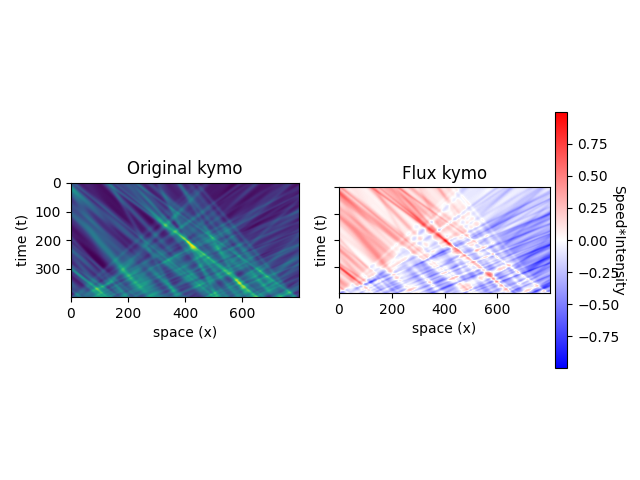

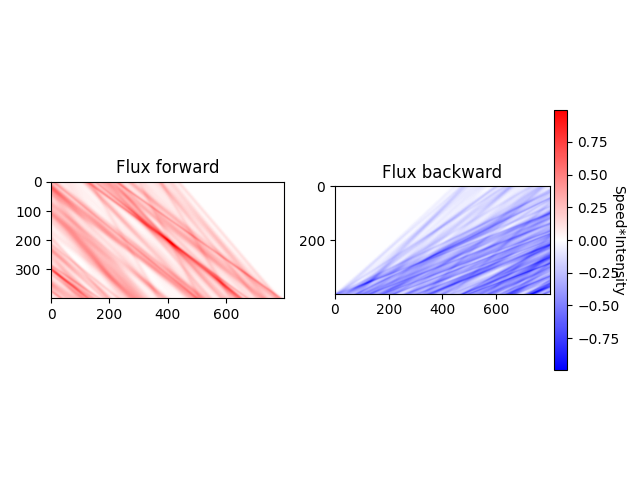

In [213]:
if display_figs:    
    fig, ax = plt.subplots(1,2, sharey = True)
    ax[0].imshow(tot_img)
    kymo_titles(ax[0], "Original kymo")
    # ax[1].imshow(feather_img)
    # kymo_titles(ax[1], "Feathered kymo")
    flx = ax[1].imshow(tot_flux, cmap='bwr', vmin = -1*flux_max, vmax = flux_max)
    kymo_titles(ax[1], "Flux kymo")
    cbar = plt.colorbar(flx, fraction=0.056, pad=0.02)
    cbar.ax.set_ylabel("Speed*Intensity", rotation=270)

    fig.tight_layout()

    fig, ax = plt.subplots(1,2)
    for i in [0,1]:
        thi = ax[i].imshow([tot_flux_forw, tot_flux_back][i], cmap='bwr', vmin = -1*flux_max, vmax = flux_max)
        ax[i].set_title("Flux {}".format(["forward", "backward"][i]))

    cbar2 = plt.colorbar(thi, fraction=0.056, pad=0.02)
    cbar2.ax.set_ylabel("Speed*Intensity", rotation=270)

    fig.tight_layout()

## Fourier Filtering
Here the original image is filtered to extract the forward and backward speeds. The filtering will lose the baseline, which means the values in the images are balanced around zero. To account for this, the average error of the reconstructed image with the original image is used to restore the proper values.

In [214]:
kymo_anal = Kymo_edge_analysis(kymo = tot_img)
back, forw = kymo_anal.fourier_kymo()
forw_back = np.add(forw, back)

zero_point = np.average(np.subtract(forw_back.flatten(),  tot_img.flatten()))

forw_thresh = np.where((forw - zero_point/2) < noise_thresh, 0, forw - zero_point/2)
back_thresh = np.where((back - zero_point/2) < noise_thresh, 0, back - zero_point/2)
forw_back_thresh = np.where((forw_back - zero_point) < noise_thresh, 0, forw_back - zero_point)

### FIGURES
View the filtered forward and backward lines, as well as the two together. Also the histograms with the original images is overlayed on the histogram of the filtered images. This is to check if they correspond.

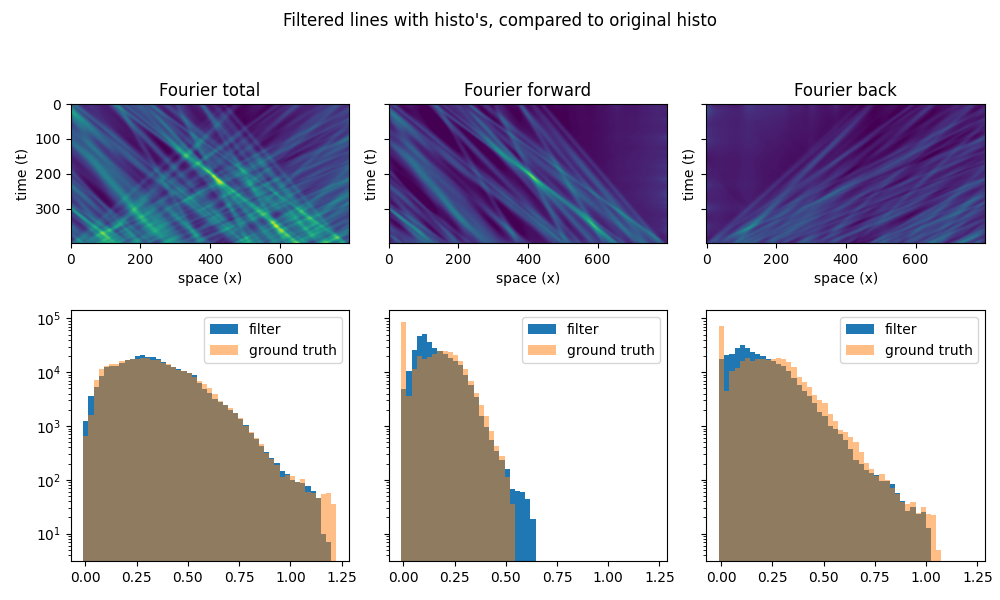

In [215]:
if display_figs:
    fig, ax = plt.subplots(2,3, sharey='row', figsize=(10, 6))
    fig.suptitle("Filtered lines with histo's, compared to original histo")
    for i in range(3):
        ax[0][i].imshow([forw_back_thresh[0], forw_thresh[0], back_thresh[0]][i], vmin = 0, vmax = img_max)
        ax[0][i].set_title("Fourier {}".format(["total", "forward", "back"][i]))
        ax[0][i].set_xlabel("space (x)")
        ax[0][i].set_ylabel("time (t)")

        ax[1][i].hist([forw_back_thresh[0].flatten(), back_thresh[0].flatten(), forw_thresh[0].flatten()][i], bins = np.linspace(-0.01, img_max, 50), log=True, label='filter')
        ax[1][i].hist([tot_img.flatten(), tot_img_back.flatten(), tot_img_forw.flatten()][i], bins = np.linspace(-0.01, img_max, 50), log=True, label='ground truth', alpha=0.5)
        ax[1][i].legend()

    fig.tight_layout()

## Speed extraction
Now that the images are filtered, both forward an backward filtered images can be used for speed extraction. These can then be added with each other to get the general flux of the kymographs.

F:\AMOLF_Projects\amftrack\pipeline\development\high_mag_videos\kymo_class.py:319: RuntimeWarning: Mean of empty slice
  np.transpose((times[j], np.nanmean(speeds[i], axis=1), edges_list, direction)),


2023-03-13 17:35:14,057-[WARNING]- matplotlib.legend:1236 -> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


F:\AMOLF_Projects\amftrack\pipeline\development\high_mag_videos\kymo_class.py:319: RuntimeWarning: Mean of empty slice
  np.transpose((times[j], np.nanmean(speeds[i], axis=1), edges_list, direction)),


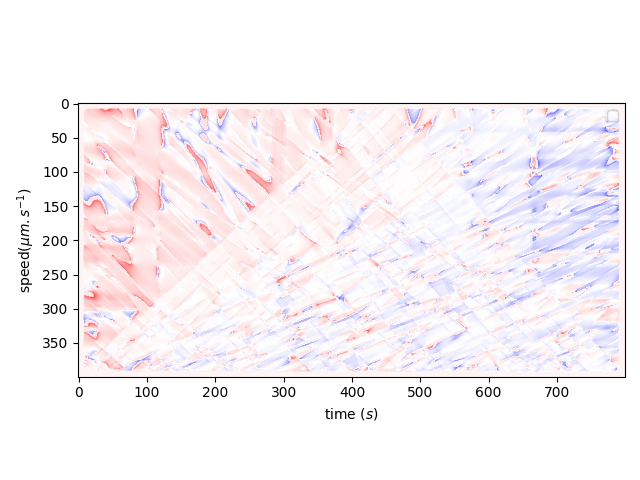

In [228]:
speeds, times = kymo_anal.extract_speeds(speed_thresh = speed_thresh, c_thr = .95, plots=False, speedplot=True, w=3)

spd_max = np.nanmax(abs(speeds.flatten()))

spds_back = np.where(speeds[0][0] < 0, speeds[0][0], 0)
spds_forw = np.where(speeds[0][1] > 0, speeds[0][1], 0)
# spds_forw = speeds[0][1]
# spds_back = speeds[0][0]

spds_back = np.where(spds_back is np.nan, 0, spds_back)
spds_forw = np.where(spds_forw is np.nan, 0, spds_forw)

kernel = np.ones((5,5),np.uint8) / 5**2

# k = cv2.getGaussianKernel(7, -1)
# kernel = k @ k.T

iters = 1

spds_back = cv2.morphologyEx(spds_back, cv2.MORPH_ERODE, kernel, iterations=iters)
spds_forw = cv2.morphologyEx(spds_forw, cv2.MORPH_DILATE, kernel, iterations=iters)
# spds_back = cv2.GaussianBlur(spds_back, (5,5), 0)
# spds_forw = cv2.GaussianBlur(spds_forw, (5,5), 0)



spds_tot = np.nansum(np.dstack((spds_back,spds_forw)),2)
flux_tot = np.nansum((np.prod((spds_forw, forw_thresh[0]), 0), np.prod((spds_back, back_thresh[0]), 0)), 0)

### FIGURES
View the extracted speeds, as well as the speeds multiplied with the lines, creating the flux images. Also compare the reconstructed flux with the ground truth, and look at the log ratio error. Lastly, there is a histogram with the fold change error. Previously, this showed a consistent fold change error of ~1.3. This was fixed by properly calculating the constant mentioned in fourier filtering. 

C:\Users\night\AppData\Local\Temp\ipykernel_18844\2959380187.py:31: RuntimeWarning: divide by zero encountered in log
  comp = ax[i].imshow([flux_tot, tot_flux, np.log(abs(flux_tot) / abs(tot_flux))][i], vmin = -1*flux_max, vmax = flux_max, cmap = 'bwr')


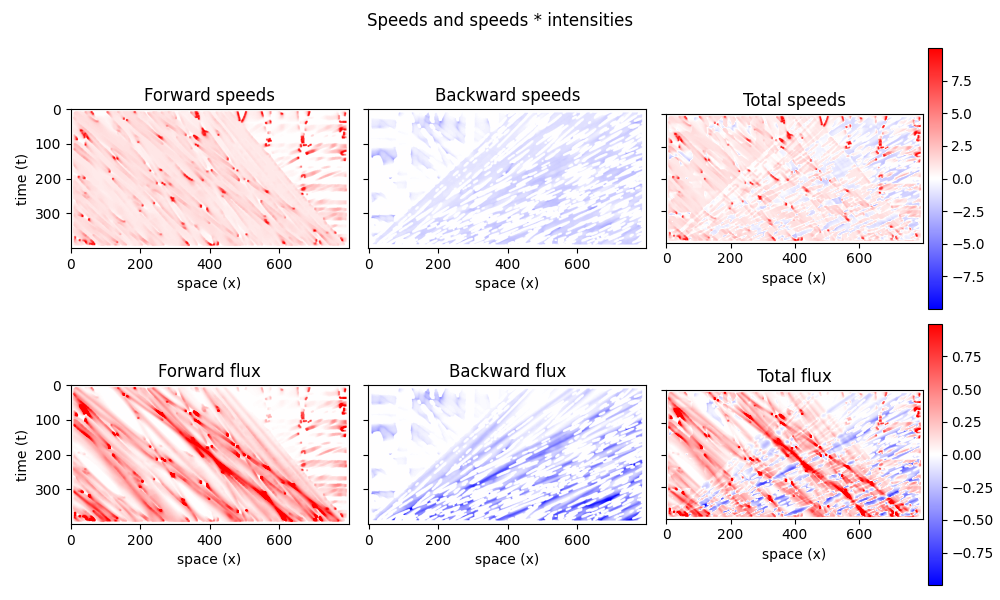

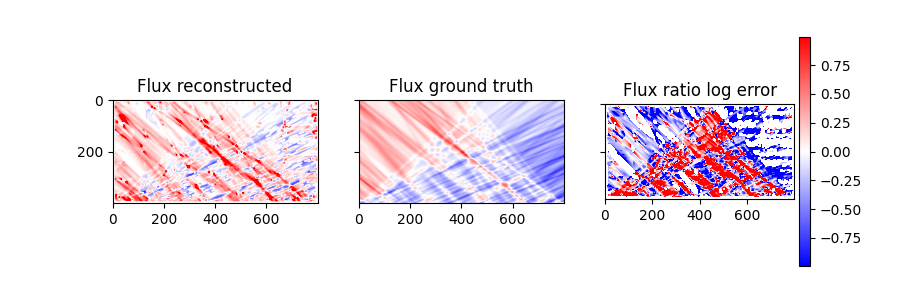

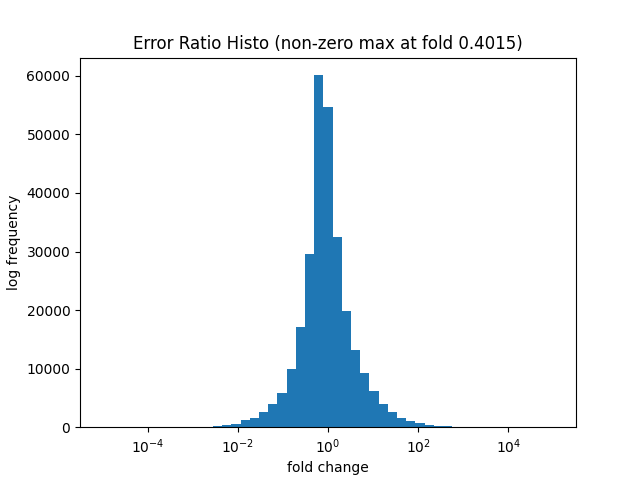

In [229]:
if display_figs:
    fig, ax = plt.subplots(2,3, sharey = 'row', figsize = (10,6))
    fig.suptitle("Speeds and speeds * intensities")
    for i in range(3):
        spds = ax[0][i].imshow([spds_forw, spds_back, spds_tot][i],
                              vmin = -1*spd_max, vmax = spd_max,
                              cmap = 'bwr'
                              )
        ax[0][i].set_title("{} speeds".format(["Forward", "Backward", "Total"][i]))
        ax[i%2][0].set_ylabel("time (t)")
        ax[0][i].set_xlabel("space (x)")
        ax[1][i].set_xlabel("space (x)")

        spdints = ax[1][i].imshow([np.prod((spds_forw, forw_thresh[0]), 0),
                                  np.prod((spds_back, back_thresh[0]), 0),
                                  flux_tot]
                                  [i],
                                  vmin = -1*flux_max, vmax = flux_max,
                                  cmap = 'bwr'
                                 )
        ax[1][i].set_title("{} flux".format(["Forward", "Backward", "Total"][i]))


    cbar3 = plt.colorbar(spds, fraction=0.056, pad=0.02)
    cbar3 = plt.colorbar(spdints, fraction=0.056, pad=0.02)
    fig.tight_layout()


    fig, ax = plt.subplots(1,3, sharey = True, figsize = (9,3))
    for i in range(3):
        comp = ax[i].imshow([flux_tot, tot_flux, np.log(abs(flux_tot) / abs(tot_flux))][i], vmin = -1*flux_max, vmax = flux_max, cmap = 'bwr')
        ax[i].set_title("Flux {}".format(["reconstructed", "ground truth", "ratio log error"][i]))
    plt.colorbar(comp, fraction=0.056, pad=0.02)

    fig, ax = plt.subplots()
    err_hist = ax.hist((abs(flux_tot) / abs(tot_flux)).flatten(), bins = np.logspace(-5, 5, 50), log=False)
    ax.set_xscale('log')
    fold_max = (err_hist[1][np.argmax(err_hist[0][1:])] + err_hist[1][np.argmax(err_hist[0][1:])+1])/2
    ax.set_title("Error Ratio Histo (non-zero max at fold {:.4})".format(fold_max))
    ax.set_xlabel("fold change")
    ax.set_ylabel("log frequency")

### FIGURES:
We're getting towards the end, here we check to see how line integrals are doing. We are plotting the ground truth net transport, the transport with just the fourier filtered images (speed is assumed to be 1), and the integral over the flux images that were created. 

In [230]:
# # fig, ax = plt.subplots(1,2, sharey=True)

# # im_l = ax[0].imshow(left - zero_point, vmin = 0, vmax = img_max)
# # kymo_titles(ax[0], "Backward filter")
# # ax[0].vlines(200, 0, 399, colors='black', label="")
# # im_r = ax[1].imshow(right - zero_point, vmin = 0, vmax = img_max)
# # kymo_titles(ax[1], "Forward filter")
# # ax[1].vlines(200, 0, 399, colors='black', label="")

# line_interest = 100

# fig, ax = plt.subplots()
# comp = ax.imshow(flux_tot, vmin = -1*flux_max, vmax = flux_max, cmap = 'bwr')
# ax.vlines(line_interest, 1, flux_tot.shape[0] -1, color='black')
# ax.set_title("reconstructed flux with line int")

# int_ax = flux_int(tot_flux, line=line_interest)
# fourier_int = np.cumsum(np.subtract(right, left).transpose()[line_interest])
# fourier_adj_int = np.nancumsum(flux_tot.transpose()[line_interest])
# fourier_avg_int = np.nancumsum(np.subtract(np.array(right)*right_avg, np.array(left)*-1*left_avg).transpose()[line_interest])
# int_ax.plot(fourier_int, label="Simple Fourier Int")
# int_ax.plot(fourier_adj_int, label="Flux Fourier Int")
# int_ax.legend()


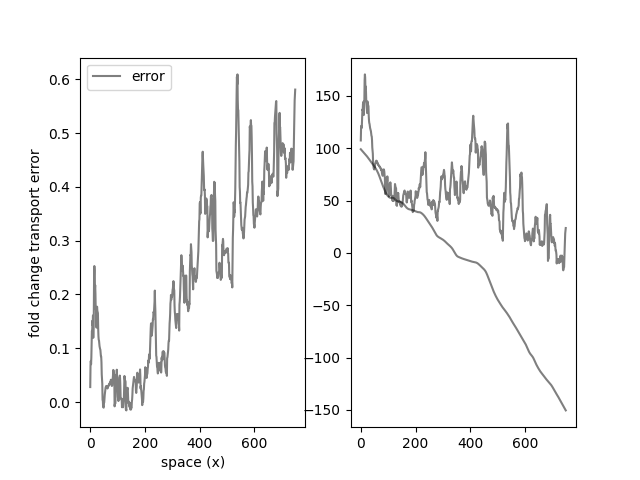

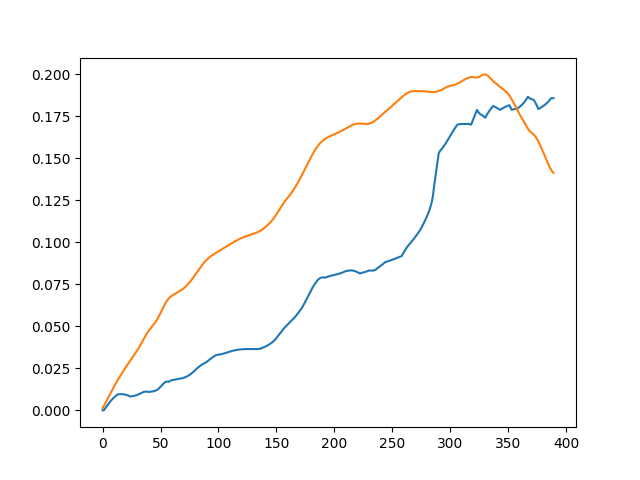

In [231]:
def extract_net_transport(line, orig_img, recon_img, margin=10):
    int_line = orig_img.transpose()[line][margin:-margin]
    int_plot = np.cumsum(int_line)
    fourier_adj_int = np.nancumsum(recon_img.transpose()[line][margin:-margin])
    return np.array([int_plot[-1] - int_plot[0], fourier_adj_int[-1] - fourier_adj_int[0]])

# print(extract_net_transport(209, flux_tot, tot_flux).shape)

fig, ax = plt.subplots(1,2)
ax[0].set_xlabel("space (x)")
ax[0].set_ylabel("fold change transport error")


trans_plots = np.array([extract_net_transport(line, tot_flux, flux_tot) for line in range(25, flux_tot.shape[1] -25)]).transpose()

# print(trans_plots.shape)

ax[0].plot((trans_plots[1] - trans_plots[0]) / nr_total_lines, color='black', alpha=0.5, label='error')
ax[1].plot(trans_plots[1], color='black', alpha=0.5, label='error')
ax[1].plot(trans_plots[0], color='black', alpha=0.5, label='error')
# ax.set_ylim([-5, 5])
# ax.hlines(1, 0, 299, label='Desired error')
ax[0].legend()

line_interest = 200
fig, ax = plt.subplots()
ax.plot(np.nancumsum(flux_tot.transpose()[line_interest][5:-5]) / nr_total_lines)
ax.plot(np.nancumsum(tot_flux.transpose()[line_interest][5:-5]) / nr_total_lines)